In [16]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import savgol_filter
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import pdist, squareform

read the csv after finding horizontal threshold, vertical thresholds. make it such that it follows the given format

final csv is the csv that has columns Id, Top-Left, Bottom-Right, Top, Left, Bottom, Right, Top_box, Bottom_box, Left_box, Right_box

Id - refers to box ID -> int

Top-Left,Bottom-Right - refers to the xy coordinates of topleft and bottomright coordinate of a bounding box

Top/Left/Bottom/Right - refers to the coordinates of edge centers

Top_box/Bottom_box/Left_box/Right_box - refers to the nearest box from current box such that the words across paragraphs or columns should not get connected -> List:[dist, nearest box ID]


      Id           Centres
0      0    [362.5, 116.0]
1      1    [646.5, 114.5]
2      2    [842.0, 116.0]
3      3   [1173.5, 119.5]
4      4   [1281.0, 118.0]
..   ...               ...
493  493  [1653.0, 3289.5]
494  494  [1806.5, 3288.0]
495  495  [2029.0, 3286.5]
496  496  [2141.5, 3282.5]
497  497  [2229.5, 3281.5]

[498 rows x 2 columns]


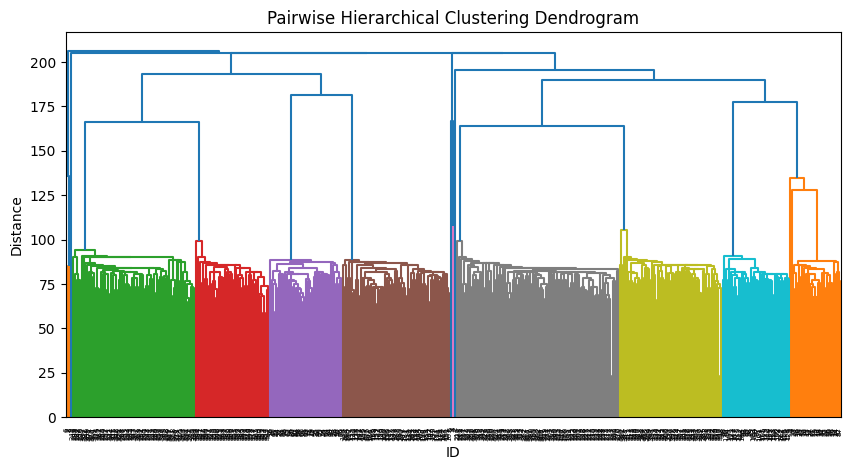

Number of Different Colors Used: 10
Cluster ID 2: IDs [161, 5, 3, 4, 2, 216, 221, 205, 218, 211, 207, 222, 329, 321, 350, 311, 348, 319, 320, 328, 312, 349, 332, 326, 333, 210, 206, 220, 299, 306, 322, 330, 314, 351, 209, 219, 214, 327, 356, 318, 355, 323, 331, 325, 353, 354, 315, 324, 352, 317, 303, 310, 307, 280, 285, 316, 283, 302, 308, 309, 300, 301, 279, 284, 271, 305, 313, 286, 240, 281, 215, 232, 196, 217, 198, 200, 197, 199, 234, 225, 233, 226, 208, 201, 202, 229, 228, 236, 227, 235, 212, 237, 213, 230, 239, 231, 238, 282, 278, 298, 277, 275, 274, 272]
      Id           Centres       X       Y
246  246  [2012.0, 1828.5]  2012.0  1828.5
247  247  [2180.5, 1828.5]  2180.5  1828.5
248  248  [1433.0, 1992.5]  1433.0  1992.5
249  249  [1525.0, 1989.0]  1525.0  1989.0
250  250  [1636.5, 1994.5]  1636.5  1994.5
..   ...               ...     ...     ...
345  345  [1997.5, 2305.5]  1997.5  2305.5
346  346  [2095.5, 2305.0]  2095.5  2305.0
347  347  [2209.0, 2309.0]  2209.0  2309.0
348

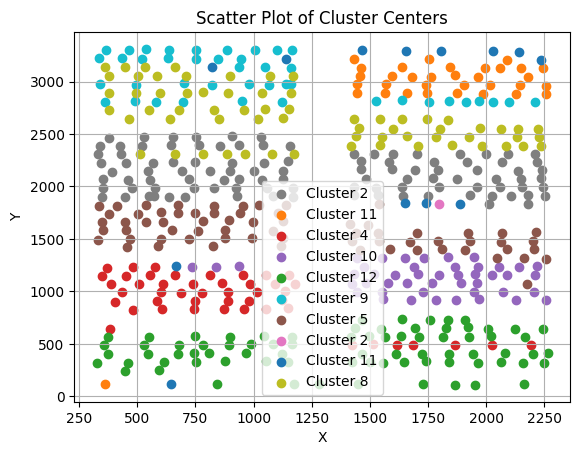

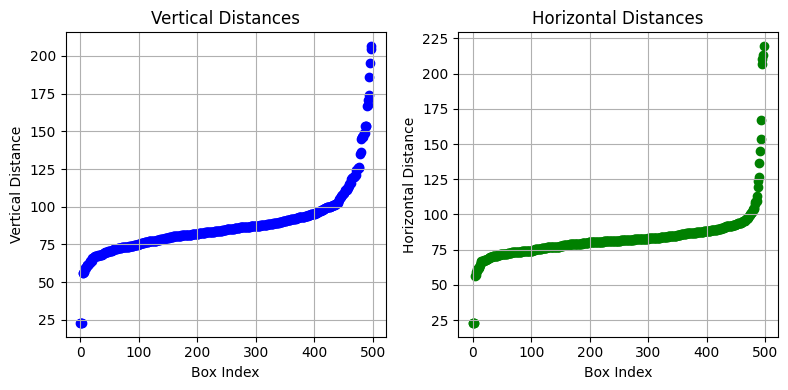

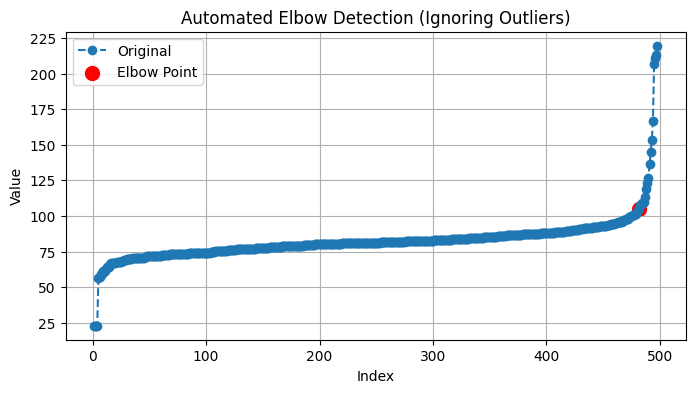

Optimal Value: 104.87730927135765
Elbow Index: 482


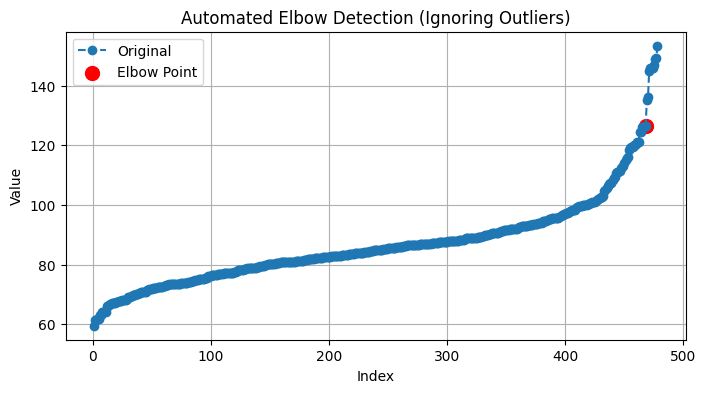

Optimal Value: 126.50098813843313
Elbow Index: 468
0
3
3
1
3
3
2
2
3
3
2
2
4
2
2
5
2
2
6
11
11
7
11
12
8
12
11
9
6
5
10
3
3
11
3
3
12
3
3
13
3
3
14
3
3
15
3
3
16
3
3
17
3
3
18
3
3
19
3
3
20
3
3
21
3
3
22
3
9
23
3
3
24
3
3
25
3
3
26
3
3
27
3
3
28
3
3
29
9
3
30
3
3
31
3
3
32
3
3
33
3
3
34
3
3
35
3
3
36
3
3
37
3
3
38
3
3
39
3
3
40
5
5
41
5
5
42
5
5
43
5
5
44
5
5
45
5
5
46
5
5
47
5
5
48
5
5
49
5
5
50
5
5
51
5
5
52
5
5
53
5
5
54
5
5
55
5
5
56
5
5
57
5
5
58
5
5
59
5
5
60
5
5
61
5
5
62
5
5
63
5
5
64
5
5
65
5
5
66
5
5
67
5
5
68
5
5
69
5
5
70
5
5
71
5
5
72
5
5
73
5
5
74
5
5
75
5
5
76
5
5
77
5
5
78
5
5
79
5
5
80
5
5
81
5
5
82
5
5
83
5
5
84
5
5
85
5
5
86
5
5
87
3
9
88
9
9
89
9
3
90
9
9
91
9
9
92
9
9
93
9
9
94
9
9
95
9
9
96
3
3
97
9
9
98
9
9
99
9
9
100
9
9
101
9
3
102
3
3
103
9
3
104
9
9
105
9
3
106
9
9
107
9
9
108
3
3
109
9
3
110
3
3
111
9
3
112
3
3
113
9
9
114
9
9
115
9
9
116
3
3
117
3
3
118
3
3
119
3
3
120
3
3
121
9
9
122
9
9
123
9
9
124
3
3
125
3
3
126
3
3
127
3
3
128
3
3
129
3
9
130
9
3
131
8

In [17]:
df = pd.read_csv('CSV/TLBR_68.csv')
def parse_coordinates(coord_str):
    # Parse the string as a JSON array
    coord_list = json.loads(coord_str)
    # Extract 'x' and 'y' values
    x, y = coord_list
    return int(x), int(y)

# Create the 'euclidean' DataFrame and initialize it with columns
euclidean = pd.DataFrame(columns=['Id', 'Top-Left', 'Bottom-Right', 'Top', 'Bottom', 'Left', 'Right', 'Top_Box', 'Bottom_Box', 'Left_Box', 'Right_Box'])
df1 = pd.DataFrame(columns=['Id', 'Centres'])
for index, row in df.iterrows():
    top_left = parse_coordinates(row['Top-Left'])
    bottom_right = parse_coordinates(row['Bottom-Right'])
    box_id = row['Id']
    # Calculate edge centers
    top_center = (top_left[0] + (bottom_right[0] - top_left[0]) / 2, top_left[1])
    bottom_center = (top_left[0] + (bottom_right[0] - top_left[0]) / 2, bottom_right[1])
    left_center = (top_left[0], top_left[1] + (bottom_right[1] - top_left[1]) / 2)
    right_center = (bottom_right[0], top_left[1] + (bottom_right[1] - top_left[1]) / 2)

    # Initialize neighbor values to -1 and 0
    top_box = (-1, 0)
    bottom_box = (-1, 0)
    left_box = (-1, 0)
    right_box = (-1, 0)

    # Add the row to the 'euclidean' DataFrame
    euclidean.loc[index] = [box_id, top_left, bottom_right, top_center, bottom_center, left_center, right_center, top_box, bottom_box, left_box, right_box]
    df1.loc[index] = [box_id, [(top_left[0]+bottom_right[0])/2, (top_left[1]+bottom_right[1])/2]]
print(df1)
df1[['X', 'Y']] = pd.DataFrame(df1['Centres'].tolist(), columns=['X', 'Y'])
# chebyshev_distances = pdist(df1[['X', 'Y']].values, metric='chebyshev')

# # Convert the condensed distance matrix to squareform
# square_distance_matrix = squareform(chebyshev_distances)

# # Calculate the linkage matrix for hierarchical clustering using Chebyshev distances
# linkage_matrix = linkage(square_distance_matrix, method='average')
linkage_matrix = linkage(df1[['X', 'Y']], method='single', metric='chebyshev')
plt.figure(figsize=(10, 5))
dendro = dendrogram(linkage_matrix, labels=df1['Id'].tolist(),color_threshold = 136, orientation='top', distance_sort='ascending')
plt.xlabel('ID')
plt.ylabel('Distance')
plt.title('Pairwise Hierarchical Clustering Dendrogram')
plt.show()
cluster_labels = fcluster(linkage_matrix, t=136, criterion='distance')  # Adjust the threshold 't' as needed
cluster_id_mapping = {}
for id_, label in zip(dendro['ivl'], cluster_labels):
    cluster_id_mapping[id_] = label
# Get the colors assigned to the labels in the dendrogram
label_colors = [dendro['color_list'][i] for i in range(len(dendro['color_list']))]

# Count the unique colors
unique_colors = set(label_colors)
num_unique_colors = len(unique_colors)

print(f'Number of Different Colors Used: {num_unique_colors}')
for color in unique_colors:
    ids_in_cluster = [id_ for id_, label_color in zip(dendro['ivl'], label_colors) if label_color == color]
    cluster_id = cluster_id_mapping.get(ids_in_cluster[0], None)  # Get cluster ID from the mapping
    print(f'Cluster ID {cluster_id}: IDs {ids_in_cluster}')
    cluster_centers = df1[np.isin(dendro['ivl'], ids_in_cluster)]
    print(cluster_centers)
    # Scatter plot for the cluster with its assigned color
    plt.scatter(cluster_centers['X'], cluster_centers['Y'], label=f'Cluster {cluster_id}', c=color)
# Customize the plot
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Cluster Centers')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)
vertical_distances = []
horizontal_distances = []
def find_nearest_box(row, direction):
    min_distance = float('inf')
    nearest_box = [-1, 0]

    for index, other_row in euclidean.iterrows():
        if row['Id'] != other_row['Id']:
            distance = float('inf')
            calc = euclidean_distance([(row['Top'][0]+row['Bottom'][0])/2, (row['Top'][1]+row['Bottom'][1])/2  ],[ (other_row['Top'][0]+other_row['Bottom'][0])/2, (other_row['Top'][1]+other_row['Bottom'][1])/2 ])
            if(direction == 'Top'):
                if(row['Top'][1] < other_row['Bottom'][1]):
                    # distance = euclidean_distance((row['Top']+row['Bottom'])/2, (other_row['Top']+other_row['Bottom'])/2)
                    distance = calc
            if(direction == 'Bottom'):
                if(row['Bottom'][1] > other_row['Top'][1]):
                    # distance = euclidean_distance((row['Top']+row['Bottom'])/2, (other_row['Top']+other_row['Bottom'])/2)
                    distance = calc
            if(direction == 'Left'):
                if(row['Left'][0] < other_row['Right'][0]):
                    # distance = euclidean_distance((row['Top']+row['Bottom'])/2, (other_row['Top']+other_row['Bottom'])/2)
                    distance = calc
            if(direction == 'Right'):
                if(row['Right'][0] > other_row['Left'][0]):
                    # distance = euclidean_distance((row['Top']+row['Bottom'])/2, (other_row['Top']+other_row['Bottom'])/2)
                    distance = calc
            if distance < min_distance:
                min_distance = distance
                nearest_box = [min_distance, other_row['Id']+1]

    return nearest_box

# Iterate through the 'euclidean' DataFrame to find the nearest boxes in each direction

for index, row in euclidean.iterrows():
    euclidean.at[index, 'Top_Box'] = find_nearest_box(row, 'Top')
    euclidean.at[index, 'Bottom_Box'] = find_nearest_box(row, 'Bottom')
    euclidean.at[index, 'Left_Box'] = find_nearest_box(row, 'Left')
    euclidean.at[index, 'Right_Box'] = find_nearest_box(row, 'Right')
    if(euclidean.at[index, 'Top_Box'][0] != -1):
        vertical_distances.append(euclidean.at[index, 'Top_Box'][0])
    if(euclidean.at[index, 'Left_Box'][0] != -1):
        horizontal_distances.append(euclidean.at[index, 'Left_Box'][0])
    # if(euclidean.at[index, 'Top_Box'][0] > 194):
    #     euclidean.at[index, 'Top_Box'][1] = 0
    # if(euclidean.at[index, 'Bottom_Box'][0] > 194):
    #     euclidean.at[index, 'Bottom_Box'][1] = 0
    # if(euclidean.at[index, 'Left_Box'][0] > 140):
    #     euclidean.at[index, 'Left_Box'][1] = 0
    # if(euclidean.at[index, 'Right_Box'][0] > 140):
    #     euclidean.at[index, 'Right_Box'][1] = 0
vertical_distances.sort()
horizontal_distances.sort()
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(vertical_distances)), vertical_distances, marker='o', color='blue')
plt.xlabel('Box Index')
plt.ylabel('Vertical Distance')
plt.title('Vertical Distances')
plt.grid()

# Create a scatter plot for horizontal distances
plt.subplot(1, 2, 2)
plt.scatter(range(len(horizontal_distances)), horizontal_distances, marker='o', color='green')
plt.xlabel('Box Index')
plt.ylabel('Horizontal Distance')
plt.title('Horizontal Distances')
plt.grid()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
values = horizontal_distances
smoothed_values = savgol_filter(values, 5, 2)  # You can adjust the window size and polynomial order

# Calculate the Z-Scores for the smoothed values to identify outliers
z_scores = zscore(smoothed_values)

# Define a threshold for outlier detection (e.g., z-score > 3 for extreme outliers)
outlier_threshold = 3

# Find the indices of non-outliers
non_outlier_indices = np.where(np.abs(z_scores) <= outlier_threshold)

# Filter the original values to keep only non-outliers
non_outlier_values = [values[i] for i in non_outlier_indices[0]]

# Calculate the second derivative of the smoothed non-outlier values
second_derivative = np.diff(np.diff(non_outlier_values))

# Find the index of the maximum value in the second derivative
elbow_index = np.argmax(second_derivative) + 2  # Add 2 to account for the two differences

# Get the corresponding optimal value from the original array
optimal_value = values[elbow_index - 1]  # Subtract 1 to convert to 0-based index

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(values) + 1), values, marker='o', linestyle='--', label='Original')
plt.scatter(elbow_index, optimal_value, c='red', marker='o', label='Elbow Point', s=100)
plt.title('Automated Elbow Detection (Ignoring Outliers)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

print(f'Optimal Value: {optimal_value}')
print(f'Elbow Index: {elbow_index}')

values = vertical_distances
values = values[10:-10]
smoothed_values = savgol_filter(values, 5, 2)  # You can adjust the window size and polynomial order

# Calculate the Z-Scores for the smoothed values to identify outliers
z_scores = zscore(smoothed_values)

# Define a threshold for outlier detection (e.g., z-score > 3 for extreme outliers)
outlier_threshold = 5

# Find the indices of non-outliers
non_outlier_indices = np.where(np.abs(z_scores) <= outlier_threshold)

# Filter the original values to keep only non-outliers
non_outlier_values = [values[i] for i in non_outlier_indices[0]]

# Calculate the second derivative of the smoothed non-outlier values
second_derivative = np.diff(np.diff(non_outlier_values))

# Find the index of the maximum value in the second derivative
elbow_index1 = np.argmax(second_derivative) + 2  # Add 2 to account for the two differences

# Get the corresponding optimal value from the original array
optimal_value1 = values[elbow_index1 - 1]  # Subtract 1 to convert to 0-based index

# Plot the original values and highlight the elbow point
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(values) + 1), values, marker='o', linestyle='--', label='Original')
plt.scatter(elbow_index1, optimal_value1, c='red', marker='o', label='Elbow Point', s=100)
plt.title('Automated Elbow Detection (Ignoring Outliers)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

# Print the optimal value and its index
print(f'Optimal Value: {optimal_value1}')
print(f'Elbow Index: {elbow_index1}')

for index, row in euclidean.iterrows():
    # print(index)
    # print(cluster_id_mapping[index])
    # print(cluster_id_mapping[euclidean.at[index, 'Top_Box'][1]-1])
    if(euclidean.at[index, 'Top_Box'][0] >= optimal_value1 or cluster_id_mapping[index] != cluster_id_mapping[euclidean.at[index, 'Top_Box'][1]-1]):
        euclidean.at[index, 'Top_Box'][1] = 0
        euclidean.at[index, 'Top_Box'][0] = -1
    if(euclidean.at[index, 'Bottom_Box'][0] >= optimal_value1 or cluster_id_mapping[index] != cluster_id_mapping[euclidean.at[index, 'Bottom_Box'][1]-1]):
        euclidean.at[index, 'Bottom_Box'][1] = 0
        euclidean.at[index, 'Bottom_Box'][0] = -1
    if(euclidean.at[index, 'Left_Box'][0] >= optimal_value or cluster_id_mapping[index] != cluster_id_mapping[euclidean.at[index, 'Left_Box'][1]-1]):
        euclidean.at[index, 'Left_Box'][0] = -1
        euclidean.at[index, 'Left_Box'][1] = 0
    if(euclidean.at[index, 'Right_Box'][0] >= optimal_value or cluster_id_mapping[index] != cluster_id_mapping[euclidean.at[index, 'Right_Box'][1]-1]):
        euclidean.at[index, 'Right_Box'][1] = 0
        euclidean.at[index, 'Right_Box'][0] = -1
# In this example, I've used sample lists for vertical and horizontal distances. You should replace these lists with your actual data. The code creates two subplots: one for vertical distances and one for horizontal distances, and it displays them side by side.
# print(euclidean)

In [18]:
img = cv2.imread('images/68.jpg')

Given below are two functions to visualize the document image and the connections established.

visualize_bboxes() can be used to visualize a document image with the bounding boxes around words. Bounding box information is given in the CSVs provided

make_connections() can be used to verify and visualize the connections established between words such that it satisfies the given criteria of grouping words in a logical paragraph. This function has to be used after getting the final csv in the specified format

In [19]:
def visualize_bboxes(img):
  img_2 = img.copy()
  for index, rows in df.iterrows():
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    # print(top_left)
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)

  plt.imshow(img_2)

In [20]:
def make_connections(image):
#   print(image)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   print(image_rgb)

  image_with_boxes = image_rgb.copy()

  for index, row in euclidean.iterrows():
      left = int(row['Left'][0])
      right = int(row['Right'][0])
      top = int(row['Top'][1])
      bottom = int(row['Bottom'][1])
      box_id = int(row['Id'])

      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

      top_adjacent_id = int(row['Top_Box'][1])
      bottom_adjacent_id = int(row['Bottom_Box'][1])
      left_adjacent_id = int(row['Left_Box'][1])
      right_adjacent_id = int(row['Right_Box'][1])
      
      # print(bottom_adjacent_id)
      
      if top_adjacent_id != 0:
          top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id-1].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id-1].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)

      if left_adjacent_id != 0:
          left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id-1].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

      if right_adjacent_id != 0:
          right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id-1].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

  return image_with_boxes

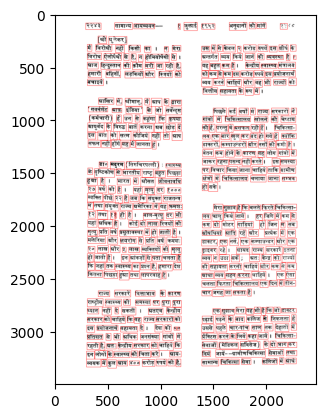

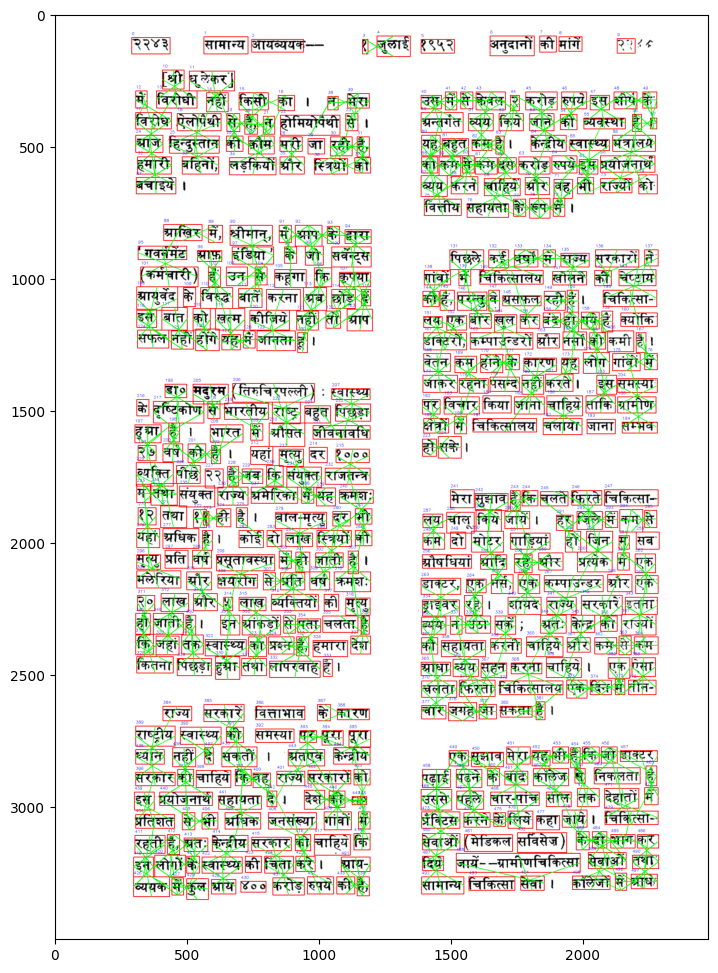

In [21]:
visualize_bboxes(img)
plt.figure(figsize=(20, 12))
plt.imshow(make_connections(img))
plt.show()

In [22]:
# import cv2
# import numpy as np

# # Load image, grayscale, Gaussian blur, Otsu's threshold
# image = cv2.imread('images/159.jpg')
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(gray, (7,7), 0)
# thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# # Create rectangular structuring element and dilate
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
# dilate = cv2.dilate(thresh, kernel, iterations=10)

# # Find contours and draw rectangle
# cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     x,y,w,h = cv2.boundingRect(c)
#     cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
# print(len(cnts))
# # cv2.imshow('thresh', thresh)
# # cv2.imshow('dilate', dilate)
# cv2.imshow('image', image)
# cv2.waitKey()